In [274]:
import os

# 0. Setup Data Paths
nhanes_step_count_dir = "./data/nhanes-step-count/"
subject_info_path = os.path.join(nhanes_step_count_dir, "subject-info.csv")
actisteps_path = os.path.join(nhanes_step_count_dir, "nhanes_1440_actisteps.csv.xz")
ac_path = os.path.join(nhanes_step_count_dir, "nhanes_1440_AC.csv.xz")
mims_path = os.path.join(nhanes_step_count_dir, "nhanes_1440_PAXMTSM.csv.xz")

nhanes_lab_dir = "./data/nhanes-lab/"
ghb_path_2011 = os.path.join(nhanes_lab_dir, "ghb-2011-12.xpt")
ghb_path_2013 = os.path.join(nhanes_lab_dir, "ghb-2013-14.xpt")

nhanes_questionnaire_dir = "./data/nhanes-questionnaire/"
bpq_path_2011 = os.path.join(nhanes_questionnaire_dir, "bpq-2011-12.xpt")
bpq_path_2013 = os.path.join(nhanes_questionnaire_dir, "bpq-2013-14.xpt")

nhanes_exam_dir = "./data/nhanes-examination/"
bmx_path_2011 = os.path.join(nhanes_exam_dir, "bmx-2011-12.xpt")
bmx_path_2013 = os.path.join(nhanes_exam_dir, "bmx-2013-14.xpt")

In [275]:
import pandas as pd

# 1. Load NHANES Step-Count Data
print("Loading Wearable Movement Data... (this may take a few minutes)")

subj_df = pd.read_csv(subject_info_path, dtype={"SEQN": "Int64"})
ac_df = pd.read_csv(ac_path, dtype={"SEQN": "Int64"}, low_memory=False)
mims_df = pd.read_csv(mims_path, dtype={"SEQN": "Int64"}, low_memory=False)

print("Wearable Data Shape:")
print("- Subject Info:", subj_df.shape)
print("- Activity Counts:", ac_df.shape)
print("- MIMS:", mims_df.shape)

Loading Wearable Movement Data... (this may take a few minutes)
Wearable Data Shape:
- Subject Info: (19931, 8)
- Activity Counts: (130186, 1443)
- MIMS: (130186, 1443)
Wearable Data Shape:
- Subject Info: (19931, 8)
- Activity Counts: (130186, 1443)
- MIMS: (130186, 1443)


In [ ]:
import numpy as np

# 2. Feature Engineering for NHANES Step-Count Data
print("Computing Wearable Data Features...")

# Compute Activity Counts Features
ac_minute_cols = [c for c in ac_df.columns if c.startswith("min_")]
ac_df["daily_AC"] = ac_df[ac_minute_cols].sum(axis=1, numeric_only=True)
ac_agg = ac_df.groupby("SEQN").agg(sd_daily_AC=("daily_AC", "std")).reset_index()
ac_agg["sd_daily_AC"] = ac_agg["sd_daily_AC"].fillna(0.0)

selected_columns = ["SEQN", "sd_daily_AC"]
df = ac_agg[selected_columns].copy()

# Compute MIMS Activity Intensity Bins
mims_minute_cols = [c for c in mims_df.columns if c.startswith("min_")]
mims_values = mims_df[mims_minute_cols].values.flatten()
mims_values_nonzero = mims_values[mims_values > 0]  # Exclude invalid data (zeros)

p25 = np.percentile(mims_values_nonzero, 25)
p95 = np.percentile(mims_values_nonzero, 95)

print(f"Computed MIMS Intensity Thresholds:")
print(f"Sedentary: MIMS > 0 and < {p25:.1f}")
print(f"Vigorous: MIMS > {p95:.1f}")

mims_vals = mims_df[mims_minute_cols].values
sedentary_mins = ((mims_vals > 0) & (mims_vals < p25)).sum(axis=1)
vigorous_mins = (mims_vals >= p95).sum(axis=1)
mims_df["sedentary_mins"] = sedentary_mins
mims_df["vigorous_mins"] = vigorous_mins

mims_agg = mims_df.groupby("SEQN").agg(
    mean_sedentary_mins=("sedentary_mins", "mean"),
    mean_vigorous_mins=("vigorous_mins", "mean"),
).reset_index()

df = df.merge(mims_agg, on="SEQN", how="left")

# Merge with Subject Info
print(subj_df.columns.tolist())
selected_columns = ["SEQN", "age_in_years_at_screening"]
subj_df = subj_df[selected_columns].copy()
df = df.merge(subj_df, on="SEQN", how="left")

print("\n--- Intensity Feature Summary ---")
print(f"Mean sedentary mins/day: {df['mean_sedentary_mins'].mean():.1f}")
print(f"Mean vigorous mins/day: {df['mean_vigorous_mins'].mean():.1f}")

df.describe()

Computing Wearable Data Features...
Computed MIMS Intensity Thresholds:
Sedentary: MIMS > 0 and < 1.0
Vigorous: MIMS > 36.9
Computed MIMS Intensity Thresholds:
Sedentary: MIMS > 0 and < 1.0
Vigorous: MIMS > 36.9
['SEQN', 'data_release_cycle', 'gender', 'age_in_years_at_screening', 'full_sample_2_year_interview_weight', 'full_sample_2_year_mec_exam_weight', 'masked_variance_pseudo_psu', 'masked_variance_pseudo_stratum']

--- Intensity Feature Summary ---
Mean sedentary mins/day: 234.7
Mean vigorous mins/day: 47.0
['SEQN', 'data_release_cycle', 'gender', 'age_in_years_at_screening', 'full_sample_2_year_interview_weight', 'full_sample_2_year_mec_exam_weight', 'masked_variance_pseudo_psu', 'masked_variance_pseudo_stratum']

--- Intensity Feature Summary ---
Mean sedentary mins/day: 234.7
Mean vigorous mins/day: 47.0


,SEQN,sd_daily_AC,mean_sedentary_mins,mean_vigorous_mins,age_in_years_at_screening
count,14693.0,1.469300e+04,14693.000000,14693.000000,14693.000000
mean,73182.610223,1.062692e+06,234.660112,47.042718,35.750561
std,6486.170446,4.441004e+05,201.927361,45.543309,23.182327
min,62161.0,0.000000e+00,0.000000,0.000000,3.000000
25%,67312.0,7.569292e+05,99.000000,12.333333,14.000000
50%,74099.0,1.028766e+06,144.888889,32.500000,33.000000
75%,78969.0,1.333697e+06,333.666667,68.888889,55.000000
max,83731.0,7.410255e+06,1280.888889,409.444444,80.000000


In [277]:
# 3. Load NHANES Questionnaire Data + Merge Features


bpq_2011 = pd.read_sas(bpq_path_2011, format="xport")
bpq_2013 = pd.read_sas(bpq_path_2013, format="xport")


bpq = pd.concat([bpq_2011, bpq_2013], ignore_index=True)
# BPQ020: Ever told you had high blood pressure
# BPQ080: Doctor told you - high cholesterol level
selected_columns = ["SEQN", "BPQ020", "BPQ080"]
bpq = bpq[selected_columns].copy()
bpq = bpq.dropna()
bpq = bpq.rename(columns={'BPQ020': 'high_blood_pressure', 'BPQ080': 'high_cholesterol'})


df = df.merge(bpq, on="SEQN", how="inner")


df.describe()

,SEQN,sd_daily_AC,mean_sedentary_mins,mean_vigorous_mins,age_in_years_at_screening,high_blood_pressure,high_cholesterol
count,10095.0,1.009500e+04,10095.000000,10095.000000,10095.000000,10095.000000,10095.000000
mean,73319.500446,9.575282e+05,238.171978,29.857635,47.330758,1.652402,1.715206
std,6475.933328,4.016700e+05,196.574201,31.715496,18.599095,0.526048,0.743788
min,62161.0,0.000000e+00,0.000000,0.000000,16.000000,1.000000,1.000000
25%,67473.5,6.871479e+05,106.333333,8.000000,31.000000,1.000000,1.000000
50%,74262.0,9.244403e+05,155.000000,20.777778,47.000000,2.000000,2.000000
75%,79129.0,1.188741e+06,320.277778,41.333333,62.000000,2.000000,2.000000
max,83729.0,5.098803e+06,1280.888889,343.666667,80.000000,9.000000,9.000000


In [278]:
# 4. Load NHANES Exammination Data + Merge Features

bmx_2011 = pd.read_sas(bmx_path_2011, format="xport")
bmx_2013 = pd.read_sas(bmx_path_2013, format="xport")

bmx = pd.concat([bmx_2011, bmx_2013], ignore_index=True)
# BMXBMI: Body Mass Index (BMI)
selected_columns = ["SEQN", "BMXBMI"]
bmx = bmx[selected_columns].copy()
bmx = bmx.dropna()
bmx = bmx.rename(columns={'BMXBMI': 'body_mass_index'})
df = df.merge(bmx, on="SEQN", how="inner")

df.describe()

,SEQN,sd_daily_AC,mean_sedentary_mins,mean_vigorous_mins,age_in_years_at_screening,high_blood_pressure,high_cholesterol,body_mass_index
count,9986.0,9.986000e+03,9986.000000,9986.000000,9986.000000,9986.000000,9986.000000,9986.000000
mean,73326.487182,9.608548e+05,237.289370,30.050645,47.243040,1.654516,1.715301,28.883968
std,6472.182502,4.004607e+05,196.024759,31.776733,18.545804,0.525950,0.742555,7.096445
min,62161.0,0.000000e+00,0.000000,0.000000,16.000000,1.000000,1.000000,13.600000
25%,67483.75,6.903926e+05,106.222222,8.111111,31.000000,1.000000,1.000000,23.900000
50%,74271.5,9.261417e+05,154.444444,20.888889,47.000000,2.000000,2.000000,27.700000
75%,79127.75,1.190196e+06,316.666667,41.555556,62.000000,2.000000,2.000000,32.400000
max,83729.0,5.098803e+06,1280.888889,343.666667,80.000000,9.000000,9.000000,82.900000


In [279]:
# 5. Load NHANES Laboratory Glycohemoglobin Data + Calculate Ground Truth Diabetes Binary

print("Loading Lab A1C Data...")

ghb_2011 = pd.read_sas("./data/nhanes-lab/ghb-2011-12.xpt", format="xport")
ghb_2013 = pd.read_sas("./data/nhanes-lab/ghb-2013-14.xpt", format="xport")

print("Lab Data Shape:")
print("- GHB 2011-2012:", ghb_2011.shape)
print("- GHB 2013-2014:", ghb_2013.shape)

print("Calculating ground truth with A1C lab data...")
ghb_2011 = ghb_2011[["SEQN", "LBXGH"]].rename(columns={"LBXGH": "a1c_2011"})
ghb_2013 = ghb_2013[["SEQN", "LBXGH"]].rename(columns={"LBXGH": "a1c_2013"})

# Combine 2011-12 and 2013-14 data
ghb = pd.concat([ghb_2011, ghb_2013], ignore_index=True)
ghb["a1c"] = ghb["a1c_2011"].combine_first(ghb["a1c_2013"])
ghb = ghb.dropna(subset=["a1c"])
ghb = ghb.drop_duplicates(subset=["SEQN"], keep="first")

# A1C Diabetes Criteria (We include prediabetes as diabetes):
#   normal < 5.7
#   prediabetes 5.7-6.4
#   diabetes >= 6.5
ghb["diabetes_binary"] = (ghb["a1c"] >= 5.7).astype(int)

selected_columns = ["SEQN", "diabetes_binary"]
ghb = ghb[selected_columns].copy()
df = df.merge(ghb, on="SEQN", how="inner")

df.describe()

Loading Lab A1C Data...
Lab Data Shape:
- GHB 2011-2012: (6549, 2)
- GHB 2013-2014: (6979, 2)
Calculating ground truth with A1C lab data...


,SEQN,sd_daily_AC,mean_sedentary_mins,mean_vigorous_mins,age_in_years_at_screening,high_blood_pressure,high_cholesterol,body_mass_index,diabetes_binary
count,9602.0,9.602000e+03,9602.000000,9602.000000,9602.000000,9602.000000,9602.000000,9602.000000,9602.000000
mean,73348.953968,9.634957e+05,235.599018,30.211757,47.321391,1.654030,1.712768,28.924724,0.374714
std,6470.569666,3.988143e+05,193.667865,31.791210,18.465162,0.528008,0.740866,7.103111,0.484074
min,62161.0,0.000000e+00,0.000000,0.000000,16.000000,1.000000,1.000000,13.600000,0.000000
25%,67495.25,6.947775e+05,106.111111,8.333333,32.000000,1.000000,1.000000,23.900000,0.000000
50%,74304.5,9.285080e+05,153.555556,21.111111,47.000000,2.000000,2.000000,27.700000,0.000000
75%,79137.75,1.190196e+06,311.944444,41.666667,62.000000,2.000000,2.000000,32.400000,1.000000
max,83729.0,5.098803e+06,1280.888889,343.666667,80.000000,9.000000,9.000000,82.900000,1.000000


In [280]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 6 Noramlize + Split Data into Train/Val/Test:

# Normalize all features before splitting
feature_cols = [col for col in df.columns if col not in ["SEQN", "diabetes_binary"]]
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

X = df.drop(columns=["SEQN", "diabetes_binary"])
y = df["diabetes_binary"].astype(int)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Split sizes (train/val/test):", len(X_train), len(X_val), len(X_test))

Split sizes (train/val/test): 6721 1440 1441


Feature columns: ['sd_daily_AC', 'mean_sedentary_mins', 'mean_vigorous_mins', 'age_in_years_at_screening', 'high_blood_pressure', 'high_cholesterol', 'body_mass_index']
Number of features: 7

--- Method 1: Mean Decrease in Impurity (Gini) ---
                  feature  importance_mdi
age_in_years_at_screening        0.246718
          body_mass_index        0.191013
       mean_vigorous_mins        0.169759
      mean_sedentary_mins        0.160119
              sd_daily_AC        0.159984
      high_blood_pressure        0.039080
         high_cholesterol        0.033326

--- Method 1: Mean Decrease in Impurity (Gini) ---
                  feature  importance_mdi
age_in_years_at_screening        0.246718
          body_mass_index        0.191013
       mean_vigorous_mins        0.169759
      mean_sedentary_mins        0.160119
              sd_daily_AC        0.159984
      high_blood_pressure        0.039080
         high_cholesterol        0.033326

--- Method 2: Permutation Import

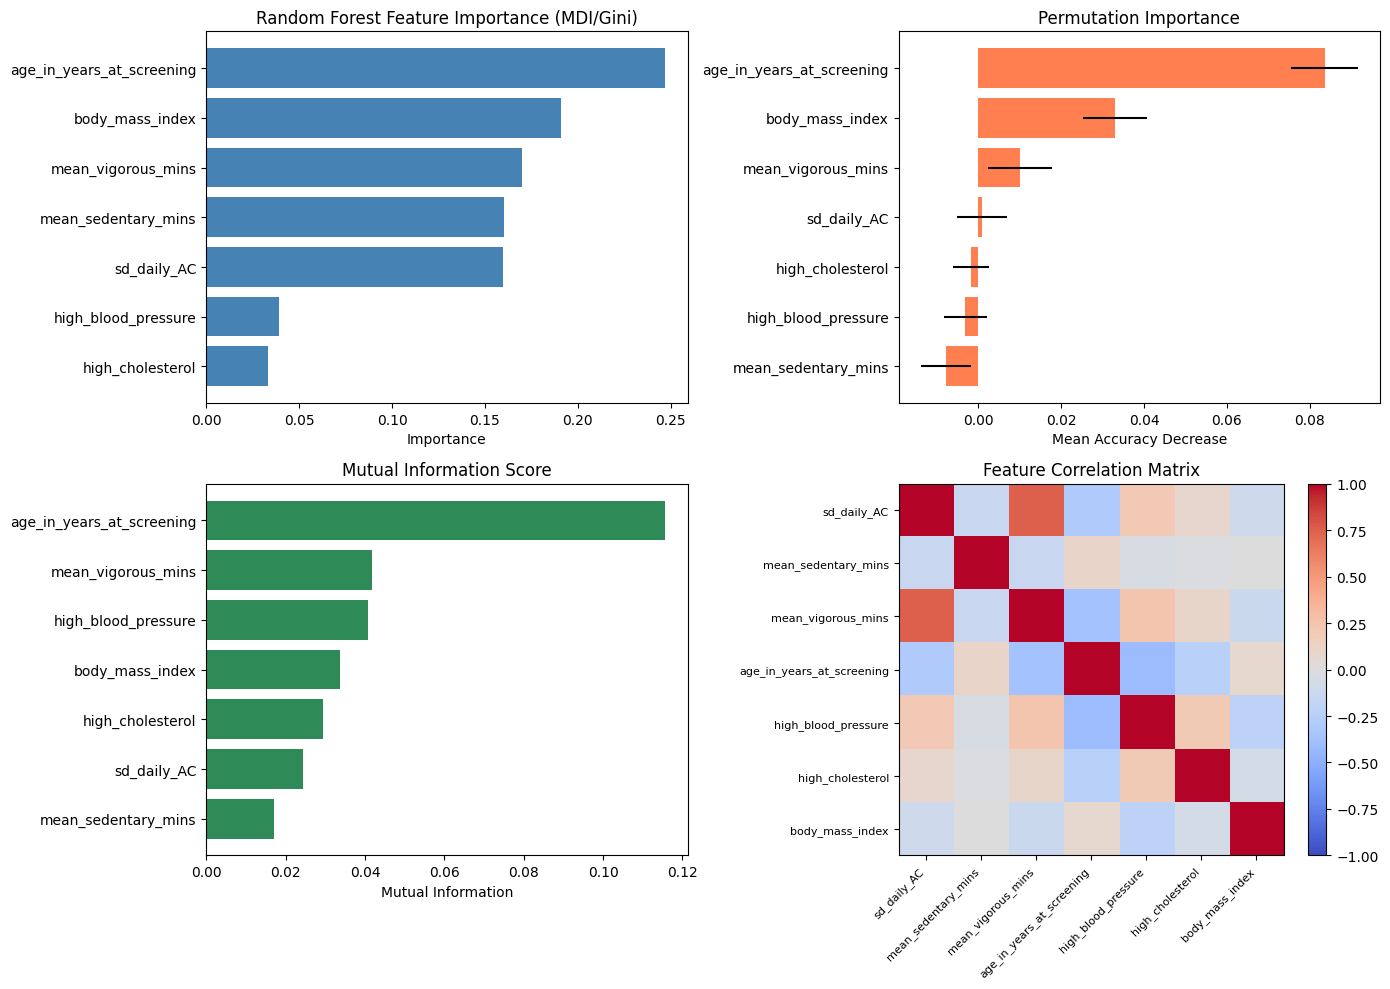


ANALYSIS SUMMARY

Highly Correlated Feature Pairs (|r| > 0.7):
  sd_daily_AC <-> mean_vigorous_mins: 0.748

--- Overall Feature Ranking (lower = more important) ---
                  feature  rank_mdi  rank_perm  rank_mi  avg_rank
              sd_daily_AC       NaN        NaN      NaN       NaN
      mean_sedentary_mins       NaN        NaN      NaN       NaN
       mean_vigorous_mins       NaN        NaN      NaN       NaN
age_in_years_at_screening       NaN        NaN      NaN       NaN
      high_blood_pressure       NaN        NaN      NaN       NaN
         high_cholesterol       NaN        NaN      NaN       NaN
          body_mass_index       NaN        NaN      NaN       NaN


In [281]:
# 6.33 - (Optional) Feature Importance Analysis
# Determine which features are most predictive of diabetes

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif
import numpy as np

print("Feature columns:", X.columns.tolist())
print(f"Number of features: {X.shape[1]}")

# --- Method 1: Random Forest Feature Importance (Gini/MDI) ---
rf_temp = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
rf_temp.fit(X_train, y_train)

feature_importance_mdi = pd.DataFrame({
    'feature': X.columns,
    'importance_mdi': rf_temp.feature_importances_
}).sort_values('importance_mdi', ascending=False)

print("\n--- Method 1: Mean Decrease in Impurity (Gini) ---")
print(feature_importance_mdi.to_string(index=False))

# --- Method 2: Permutation Importance (more reliable) ---
perm_importance = permutation_importance(rf_temp, X_val, y_val, n_repeats=30, random_state=42, n_jobs=-1)

feature_importance_perm = pd.DataFrame({
    'feature': X.columns,
    'importance_perm': perm_importance.importances_mean,
    'std': perm_importance.importances_std
}).sort_values('importance_perm', ascending=False)

print("\n--- Method 2: Permutation Importance ---")
print(feature_importance_perm.to_string(index=False))

# --- Method 3: Mutual Information ---
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
feature_importance_mi = pd.DataFrame({
    'feature': X.columns,
    'mutual_info': mi_scores
}).sort_values('mutual_info', ascending=False)

print("\n--- Method 3: Mutual Information ---")
print(feature_importance_mi.to_string(index=False))

# --- Method 4: Correlation with target ---
correlations = X_train.corrwith(y_train).abs().sort_values(ascending=False)
print("\n--- Method 4: Absolute Correlation with Target ---")
print(correlations)

# --- Visualization ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: MDI Importance
ax1 = axes[0, 0]
feature_importance_mdi_sorted = feature_importance_mdi.sort_values('importance_mdi', ascending=True)
ax1.barh(feature_importance_mdi_sorted['feature'], feature_importance_mdi_sorted['importance_mdi'], color='steelblue')
ax1.set_xlabel('Importance')
ax1.set_title('Random Forest Feature Importance (MDI/Gini)')

# Plot 2: Permutation Importance
ax2 = axes[0, 1]
feature_importance_perm_sorted = feature_importance_perm.sort_values('importance_perm', ascending=True)
ax2.barh(feature_importance_perm_sorted['feature'], feature_importance_perm_sorted['importance_perm'], 
         xerr=feature_importance_perm_sorted['std'], color='coral')
ax2.set_xlabel('Mean Accuracy Decrease')
ax2.set_title('Permutation Importance')

# Plot 3: Mutual Information
ax3 = axes[1, 0]
feature_importance_mi_sorted = feature_importance_mi.sort_values('mutual_info', ascending=True)
ax3.barh(feature_importance_mi_sorted['feature'], feature_importance_mi_sorted['mutual_info'], color='seagreen')
ax3.set_xlabel('Mutual Information')
ax3.set_title('Mutual Information Score')

# Plot 4: Feature Correlation Matrix
ax4 = axes[1, 1]
corr_matrix = X_train.corr()
im = ax4.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
ax4.set_xticks(range(len(X.columns)))
ax4.set_yticks(range(len(X.columns)))
ax4.set_xticklabels(X.columns, rotation=45, ha='right', fontsize=8)
ax4.set_yticklabels(X.columns, fontsize=8)
ax4.set_title('Feature Correlation Matrix')
plt.colorbar(im, ax=ax4)

plt.tight_layout()
plt.show()

# --- Summary: Identify redundant features ---
print("\n" + "="*60)
print("ANALYSIS SUMMARY")
print("="*60)

# Find highly correlated feature pairs (potential redundancy)
print("\nHighly Correlated Feature Pairs (|r| > 0.7):")
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            print(f"  {corr_matrix.columns[i]} <-> {corr_matrix.columns[j]}: {corr_matrix.iloc[i, j]:.3f}")

# Rank features by average rank across methods
ranks = pd.DataFrame({'feature': X.columns})
ranks['rank_mdi'] = feature_importance_mdi.set_index('feature').loc[X.columns, 'importance_mdi'].rank(ascending=False)
ranks['rank_perm'] = feature_importance_perm.set_index('feature').loc[X.columns, 'importance_perm'].rank(ascending=False)
ranks['rank_mi'] = feature_importance_mi.set_index('feature').loc[X.columns, 'mutual_info'].rank(ascending=False)
ranks['avg_rank'] = ranks[['rank_mdi', 'rank_perm', 'rank_mi']].mean(axis=1)
ranks = ranks.sort_values('avg_rank')

print("\n--- Overall Feature Ranking (lower = more important) ---")
print(ranks.to_string(index=False))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# 6.67 - (Optional) Hyperparameter Tuning for Random Forest with GridSearchCV

param_grid = {
    'n_estimators': [100, 300, 500, 700, 900],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=make_scorer(f1_score),
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search.best_params_)
print(f"Best F1 score: {grid_search.best_score_:.4f}")

# Use best estimator to predict on validation and test sets
y_val_pred = grid_search.best_estimator_.predict(X_val)
y_test_pred = grid_search.best_estimator_.predict(X_test)

print("Validation F1:", f1_score(y_val, y_val_pred))
print("Test F1:", f1_score(y_test, y_test_pred))

# Best parameters found:
# {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
# Best F1 score: 0.6658
# Validation F1: 0.6624405705229794
# Test F1: 0.6816720257234726

Fitting 3 folds for each of 225 candidates, totalling 675 fits
Best parameters found:
{'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best F1 score: 0.6658
Validation F1: 0.6624405705229794
Test F1: 0.6816720257234726
Best parameters found:
{'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best F1 score: 0.6658
Validation F1: 0.6624405705229794
Test F1: 0.6816720257234726


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score, confusion_matrix

# 7. Train Random Forest Model

rf_model = RandomForestClassifier(
    n_estimators=100, 
    class_weight="balanced", 
    random_state=42, 
    max_depth=5, 
    min_samples_leaf=1, 
    min_samples_split=10
)
rf_model.fit(X_train, y_train)

# choose threshold by maximizing F1 on validation
y_val_prob = rf_model.predict_proba(X_val)[:, 1]
best_t, best_f1 = 0.0, -1.0
for t in np.linspace(0.05, 0.95, 200):
    preds = (y_val_prob >= t).astype(int)
    score = f1_score(y_val, preds)
    if score > best_f1:
        best_f1 = score
        best_t = t
print("Best validation threshold:", best_t, "F1:", best_f1)

y_test_prob = rf_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_prob >= best_t).astype(int)

print("\nRandom Forest Model Results:")
print("Test Precision:", precision_score(y_test, y_test_pred))
print("Test Recall:", recall_score(y_test, y_test_pred))
print("Test F1:", f1_score(y_test, y_test_pred))
print("Test PR AUC:", average_precision_score(y_test, y_test_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


# Random Forest Model Results:
# Test Precision: 0.5863874345549738
# Test Recall: 0.8296296296296296
# Test F1: 0.6871165644171779
# Test PR AUC: 0.67923117303371
# Confusion Matrix:
#  [[585 316]
#  [ 92 448]]

Best validation threshold: 0.46608040201005024 F1: 0.6712328767123288

Random Forest Model Results:
Test Precision: 0.5863874345549738
Test Recall: 0.8296296296296296
Test F1: 0.6871165644171779
Test PR AUC: 0.67923117303371
Confusion Matrix:
 [[585 316]
 [ 92 448]]


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# 7.5 - (Optional) Hyperparameter Tuning for XGBoost with GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'scale_pos_weight': [1, 2, 5]
}

xgb = XGBClassifier(random_state=42, eval_metric='logloss')
grid_search = GridSearchCV(xgb, param_grid, scoring='f1', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search.best_params_)
print(f"Best F1 score: {grid_search.best_score_:.4f}")

# Use best estimator to predict on validation and test sets
y_val_pred = grid_search.best_estimator_.predict(X_val)
y_test_pred = grid_search.best_estimator_.predict(X_test)

print("Validation F1:", f1_score(y_val, y_val_pred))
print("Test F1:", f1_score(y_test, y_test_pred))

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score, confusion_matrix

# 7. Train Random Forest Model

rf_model = RandomForestClassifier(
    n_estimators=100, 
    class_weight="balanced", 
    random_state=42, 
    max_depth=5, 
    min_samples_leaf=1, 
    min_samples_split=10
)
rf_model.fit(X_train, y_train)

# choose threshold by maximizing F1 on validation
y_val_prob = rf_model.predict_proba(X_val)[:, 1]
best_t, best_f1 = 0.0, -1.0
for t in np.linspace(0.05, 0.95, 200):
    preds = (y_val_prob >= t).astype(int)
    score = f1_score(y_val, preds)
    if score > best_f1:
        best_f1 = score
        best_t = t
print("Best validation threshold:", best_t, "F1:", best_f1)

y_test_prob = rf_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_prob >= best_t).astype(int)

print("\nRandom Forest Model Results:")
print("Test Precision:", precision_score(y_test, y_test_pred))
print("Test Recall:", recall_score(y_test, y_test_pred))
print("Test F1:", f1_score(y_test, y_test_pred))
print("Test PR AUC:", average_precision_score(y_test, y_test_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


# Best parameters found:
# {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 2}
# Best F1 score: 0.6685
# Validation F1: 0.6646525679758308
# Test F1: 0.6854103343465046

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 2}
Best F1 score: 0.6685
Validation F1: 0.6646525679758308
Test F1: 0.6854103343465046


In [ ]:
# 8. Train XGBoost Model

from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    scale_pos_weight=2,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

# Threshold tuning on validation set
y_val_prob_xgb = xgb_model.predict_proba(X_val)[:, 1]
best_t_xgb, best_f1_xgb = 0.0, -1.0
for t in np.linspace(0.05, 0.95, 200):
    preds = (y_val_prob_xgb >= t).astype(int)
    score = f1_score(y_val, preds)
    if score > best_f1_xgb:
        best_f1_xgb = score
        best_t_xgb = t
print("XGBoost - Best validation threshold:", best_t_xgb, "F1:", best_f1_xgb)

y_test_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_test_pred_xgb = (y_test_prob_xgb >= best_t_xgb).astype(int)

print("\nXGBoost Model Results:")
print("Test Precision:", precision_score(y_test, y_test_pred_xgb))
print("Test Recall:", recall_score(y_test, y_test_pred_xgb))
print("Test F1:", f1_score(y_test, y_test_pred_xgb))
print("Test PR AUC:", average_precision_score(y_test, y_test_prob_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_xgb))

# XGBoost Model Results:
# Test Precision: 0.6039603960396039
# Test Recall: 0.7907407407407407
# Test F1: 0.6848436246992783
# Test PR AUC: 0.6856126674946798
# Confusion Matrix:
#  [[621 280]
#  [113 427]]

XGBoost - Best validation threshold: 0.5520100502512563 F1: 0.6677265500794912

XGBoost Model Results:
Test Precision: 0.6039603960396039
Test Recall: 0.7907407407407407
Test F1: 0.6848436246992783
Test PR AUC: 0.6856126674946798
Confusion Matrix:
 [[621 280]
 [113 427]]


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# 8.5 - (Optional) Hyperparameter Tuning for MLP Neural Network with GridSearchCV

X_train_scaled = X_train
X_val_scaled = X_val
X_test_scaled = X_test

param_grid = {
    'hidden_layer_sizes': [(64,), (64, 32), (64, 32, 16), (128, 64), (128, 64, 32)],
    'activation': ['relu', 'tanh'],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01],
    'alpha': [0.0001, 0.001, 0.01],
}

# Use early_stopping in the base estimator to prevent overfitting
mlp = MLPClassifier(
    random_state=42,
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10
)

grid_search = GridSearchCV(mlp, param_grid, scoring='f1', cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters found:")
print(grid_search.best_params_)
print(f"Best CV F1 score: {grid_search.best_score_:.4f}")

# Evaluate on validation and test sets
y_val_pred = grid_search.best_estimator_.predict(X_val_scaled)
y_test_pred = grid_search.best_estimator_.predict(X_test_scaled)

print(f"Validation F1: {f1_score(y_val, y_val_pred):.4f}")
print(f"Test F1: {f1_score(y_test, y_test_pred):.4f}")

# Best parameters found:
# {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (128, 64, 32), 'learning_rate': 'constant', 'learning_rate_init': 0.01}
# Best CV F1 score: 0.6489
# Validation F1: 0.6633
# Test F1: 0.6857

Best parameters found:
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (128, 64, 32), 'learning_rate': 'constant', 'learning_rate_init': 0.01}
Best CV F1 score: 0.6489

Validation F1: 0.6633
Test F1: 0.6857


In [ ]:
# 9. Train Neural Network (MLP)

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Data is already normalized above, so no need to scale again
X_train_scaled = X_train
X_val_scaled = X_val
X_test_scaled = X_test

# Calculate class weights for the loss function
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight('balanced', y_train)

mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='tanh',
    solver='adam',
    learning_rate='constant',
    learning_rate_init=0.01,
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42,
    verbose=False,
    alpha=0.01,
)
mlp_model.fit(X_train_scaled, y_train)

# Threshold tuning on validation set
y_val_prob_mlp = mlp_model.predict_proba(X_val_scaled)[:, 1]
best_t_mlp, best_f1_mlp = 0.0, -1.0
for t in np.linspace(0.05, 0.95, 200):
    preds = (y_val_prob_mlp >= t).astype(int)
    score = f1_score(y_val, preds)
    if score > best_f1_mlp:
        best_f1_mlp = score
        best_t_mlp = t
print("MLP - Best validation threshold:", best_t_mlp, "F1:", best_f1_mlp)

y_test_prob_mlp = mlp_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred_mlp = (y_test_prob_mlp >= best_t_mlp).astype(int)

print("\nMLP Neural Network Model Results:")
print("Test Precision:", precision_score(y_test, y_test_pred_mlp))
print("Test Recall:", recall_score(y_test, y_test_pred_mlp))
print("Test F1:", f1_score(y_test, y_test_pred_mlp))
print("Test PR AUC:", average_precision_score(y_test, y_test_prob_mlp))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_mlp))

# MLP Neural Network Model Results:
# Test Precision: 0.604306864064603
# Test Recall: 0.8314814814814815
# Test F1: 0.6999220576773187
# Test PR AUC: 0.6834462152855122
# Confusion Matrix:
#  [[607 294]
#  [ 91 449]]


MLP - Best validation threshold: 0.3801507537688442 F1: 0.674400618716164

MLP Neural Network Model Results:
Test Precision: 0.604306864064603
Test Recall: 0.8314814814814815
Test F1: 0.6999220576773187
Test PR AUC: 0.6834462152855122
Confusion Matrix:
 [[607 294]
 [ 91 449]]


In [ ]:
# 10. Ensemble Methods - Combining RF, XGBoost, and MLP

# Get probability predictions from all models
probs_rf = rf_model.predict_proba(X_test)[:, 1]
probs_xgb = xgb_model.predict_proba(X_test)[:, 1]
probs_mlp = mlp_model.predict_proba(X_test_scaled)[:, 1]

# Get validation probabilities for threshold tuning
val_probs_rf = rf_model.predict_proba(X_val)[:, 1]
val_probs_xgb = xgb_model.predict_proba(X_val)[:, 1]
val_probs_mlp = mlp_model.predict_proba(X_val_scaled)[:, 1]

# Calculate Weights for Weighted Average based on validation PR-AUC
w_rf = average_precision_score(y_val, val_probs_rf)
w_xgb = average_precision_score(y_val, val_probs_xgb)
w_mlp = average_precision_score(y_val, val_probs_mlp)
total_w = w_rf + w_xgb + w_mlp
w_rf, w_xgb, w_mlp = w_rf/total_w, w_xgb/total_w, w_mlp/total_w
print(f"Learned weights - RF: {w_rf:.3f}, XGB: {w_xgb:.3f}, MLP: {w_mlp:.3f}")

ensemble_weighted_val = w_rf * val_probs_rf + w_xgb * val_probs_xgb + w_mlp * val_probs_mlp
ensemble_weighted_test = w_rf * probs_rf + w_xgb * probs_xgb + w_mlp * probs_mlp

# Find threshold that achieves ~80% recall
target_recall=0.80
best_t, best_f1 = 0.0, -1.0
for t in np.linspace(0.01, 0.95, 300):
    preds = (ensemble_weighted_val >= t).astype(int)
    rec = recall_score(y_val, preds)
    if rec >= target_recall:
        f1 = f1_score(y_val, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t


y_pred = (ensemble_weighted_test >= best_t).astype(int)

prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
pr_auc = average_precision_score(y_test, ensemble_weighted_test)

print(f"\nFinal Weighted Avg. Ensemble Model Results:")
print(f"Threshold: {best_t:.3f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1: {f1:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

# Final Weighted Avg. Ensemble Model Results:
# Threshold: 0.475
# Precision: 0.6086
# Recall: 0.8148
# F1: 0.6968
# PR AUC: 0.6906
# Confusion Matrix:
# [[618 283]
#  [100 440]]


Learned weights - RF: 0.333, XGB: 0.337, MLP: 0.331

Final Weighted Avg. Ensemble Model Results:
Threshold: 0.475
Precision: 0.6086
Recall: 0.8148
F1: 0.6968
PR AUC: 0.6906
Confusion Matrix:
[[618 283]
 [100 440]]

Final Weighted Avg. Ensemble Model Results:
Threshold: 0.475
Precision: 0.6086
Recall: 0.8148
F1: 0.6968
PR AUC: 0.6906
Confusion Matrix:
[[618 283]
 [100 440]]
